## Библиотеки и функции для всех экспериментов

In [ ]:
%matplotlib inline
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn
from torchsummary import summary
from torch import optim
from IPython.display import clear_output
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
train_dataset = datasets.MNIST(root='mnist', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='mnist', train=False, download=True, transform=transforms.ToTensor())

In [ ]:
def run(model, dataloader, loss_function, optimizer=None):
    if optimizer == None:
        model.eval()
    else:
        model.train()

    total_loss = 0

    for X, y in dataloader:
        pred = model(X)
        loss = loss_function(pred, y)
        total_loss += loss.item()
        if optimizer != None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    return total_loss / len(dataloader)

In [ ]:
def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(10,3))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

In [ ]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            preds = model(X)
            pred_labels = preds.argmax(dim=1).cpu().numpy()
            labels = y.cpu().numpy()
            all_preds.extend(pred_labels)
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1


## 1 эксперимент (Полносвязная сеть с двумя скрытыми слоями (128 → 64) без дополнительной регуляризации, 10 эпох)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

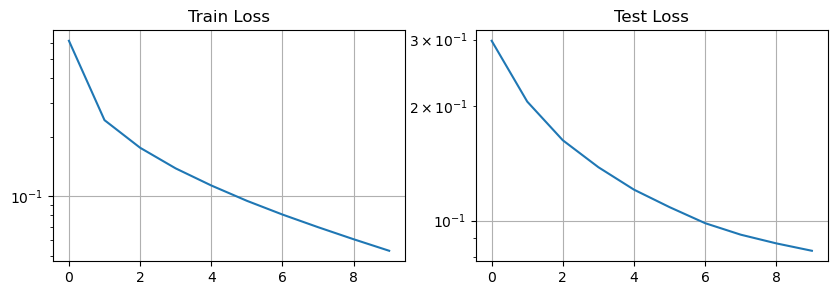

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 10

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_loss_hist = []
test_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, test_loader, loss_function)
    test_loss_hist.append(test_loss)

    if i % 2 == 1:
        show_losses(train_loss_hist, test_loss_hist)

In [ ]:
accuracy, precision, recall, f1 = compute_metrics(model, test_loader)

print("Accuracy (Test):", accuracy)
print("Precision (Test):", precision)
print("Recall (Test):", recall)
print("F1 Score (Test):", f1)

min_loss = min(test_loss_hist)
print("Минимальная ошибка (Test Loss):", min_loss)

Accuracy (Test): 0.9725
Precision (Test): 0.9727005460426555
Recall (Test): 0.9725
F1 Score (Test): 0.9725006720365574
Минимальная ошибка (Test Loss): 0.08323759896797128


## Выводы
Модель обучалась на 10 эпохах, при этом по графикам видно, что обучение можно продолжать, так как loss продолжает падать. Отсутсвие регуляризации существенно не сказалось для данной модели, так как переобучение не успело возникнуть.
Но можно заметить, что модель показала достаточно неплохую точность, задействовав небольшое количество вычислительных ресурсов.

## 2 эксперимент (Полносвязная сеть с двумя скрытыми слоями (128 → 64) без дополнительной регуляризации, 100 эпох)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


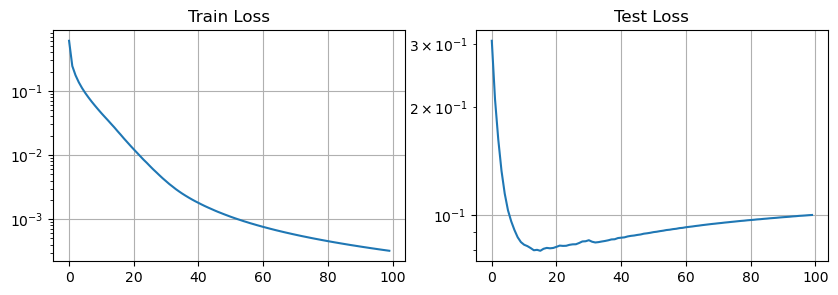

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 100

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_loss_hist = []
test_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, test_loader, loss_function)
    test_loss_hist.append(test_loss)

    if i % 2 == 1:
        show_losses(train_loss_hist, test_loss_hist)


In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

In [ ]:
accuracy, precision, recall, f1 = compute_metrics(model, test_loader)

print("Accuracy (Test):", accuracy)
print("Precision (Test):", precision)
print("Recall (Test):", recall)
print("F1 Score (Test):", f1)

min_loss = min(test_loss_hist)
print("Минимальная ошибка (Test Loss):", min_loss)

Accuracy (Test): 0.9799
Precision (Test): 0.9799052504949759
Recall (Test): 0.9799
F1 Score (Test): 0.979896162628224
Минимальная ошибка (Test Loss): 0.0797084447837551


## Выводы
Данная модель обучалась на 100 эпохах, по графику test loss видно, что модель начала переобучаться, и loss на валидационной выборке растет. В данной ситуации сказывается остутствие регуляризации - модель плохо борется с переобучением. При этом метрики получились лучше, чем у предыдущей модели.

## 3 эксперимент (Полносвязная сеть с 4 скрытыми слоями (256 - 128 - 64 - 32) без дополнительной регуляризации, 100 эпох, функция активации LeakyReLU)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.LeakyReLU(negative_slope=0.1),

    nn.Linear(256, 128),
    nn.LeakyReLU(negative_slope=0.1),

    nn.Linear(128, 64),
    nn.LeakyReLU(negative_slope=0.1),

    nn.Linear(64, 32),
    nn.LeakyReLU(negative_slope=0.1),

    nn.Linear(32, 10)
)

summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
         LeakyReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
         LeakyReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
         LeakyReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
         LeakyReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.93
Estimated T

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

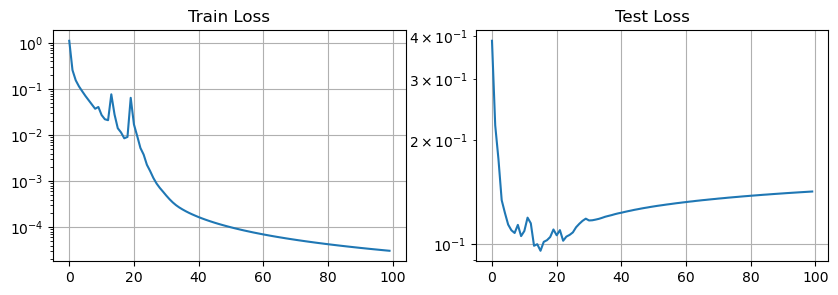

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 100

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_loss_hist = []
test_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, test_loader, loss_function)
    test_loss_hist.append(test_loss)

    if i % 2 == 1:
        show_losses(train_loss_hist, test_loss_hist)


In [ ]:
accuracy, precision, recall, f1 = compute_metrics(model, test_loader)

print("Accuracy (Test):", accuracy)
print("Precision (Test):", precision)
print("Recall (Test):", recall)
print("F1 Score (Test):", f1)

min_loss = min(test_loss_hist)
print("Минимальная ошибка (Test Loss):", min_loss)

Accuracy (Test): 0.9809
Precision (Test): 0.9809268812792689
Recall (Test): 0.9809
F1 Score (Test): 0.9808993083259651
Минимальная ошибка (Test Loss): 0.09550153402336946


## Выводы
Модель также обучалась на 100 эпохах, как и предыдущая нейросеть данная модель столкнулась с переобучением (loss на валидационной выборке растет). Также на графиках появились скачки, что может быть связано с изменением функции активации на LeakyReLU. При этом увелечение количества скрытых слоев принесло лишь незначительное улучшение метрик, так как переобучение не позволило модели показать лучшие результаты.

## 4 эксперимент (Полносвязная сеть с двумя скрытыми слоями (128 → 64), dropout, 100 эпох)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=64, out_features=10),
)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
           Dropout-7                   [-1, 64]               0
            Linear-8                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

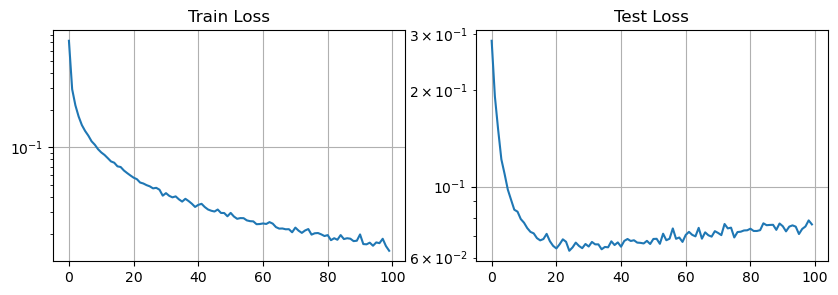

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 100

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_loss_hist = []
test_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, test_loader, loss_function)
    test_loss_hist.append(test_loss)

    if i % 2 == 1:
        show_losses(train_loss_hist, test_loss_hist)

In [ ]:
accuracy, precision, recall, f1 = compute_metrics(model, test_loader)

print("Accuracy (Test):", accuracy)
print("Precision (Test):", precision)
print("Recall (Test):", recall)
print("F1 Score (Test):", f1)

min_loss = min(test_loss_hist)
print("Минимальная ошибка (Test Loss):", min_loss)

Accuracy (Test): 0.9823
Precision (Test): 0.9823251862266077
Recall (Test): 0.9823
F1 Score (Test): 0.9822991540173287
Минимальная ошибка (Test Loss): 0.06299167365104949


## Выводы
В модель добавлен dropout, который существенно снизил переобучение модели. По графику test loss можно заметить, что loss растет незначительно. Как результат, метрики еще улучшились по сравнению с предыдущим экспериментом. Также стоит отметить, что на графиках появились небольшие скачки, что говорит об успешном применении dropout.

## 5 эксперимент (Полносвязная сеть с двумя скрытыми слоями (128 → 64), dropout, batchnorm, 100 эпох)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(p=0.2),

    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(p=0.2),

    nn.Linear(64, 10)
)
summary(model, input_size=(1, 28, 28))

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

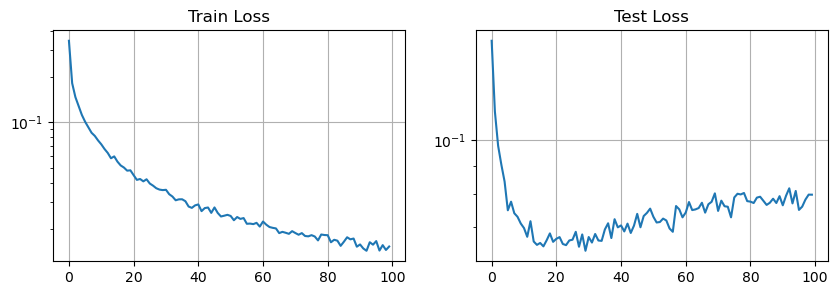

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 100

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_loss_hist = []
test_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, test_loader, loss_function)
    test_loss_hist.append(test_loss)

    if i % 2 == 1:
        show_losses(train_loss_hist, test_loss_hist)

In [ ]:
accuracy, precision, recall, f1 = compute_metrics(model, test_loader)

print("Accuracy (Test):", accuracy)
print("Precision (Test):", precision)
print("Recall (Test):", recall)
print("F1 Score (Test):", f1)

min_loss = min(test_loss_hist)
print("Минимальная ошибка (Test Loss):", min_loss)

Accuracy (Test): 0.9824
Precision (Test): 0.9824306682940556
Recall (Test): 0.9824
F1 Score (Test): 0.9823974529476889
Минимальная ошибка (Test Loss): 0.06342357680467103


## Выводы
В модель кроме dropout добавлен еще и BatchNorm. Этот слой необходим для нормализации активаций после линейных слоев. Сравнивая графики данной модели с предыдущей можно сделать вывод, что существенных изменений не произошло. Метрики после обучения также остались практически неизменными.
Это может быть связано с достаточно неглубокой архитектурой модели, а также с достаточно высокими результатами работы модели только с dropout.

## 6 эксперимент (Полносвязная сеть с 4 скрытыми слоями (256 - 128 - 64 - 32), dropout, 100 эпох)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Dropout(p=0.2),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.2),

    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.2),

    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(p=0.2),

    nn.Linear(32, 10)
)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
          Dropout-10                   [-1, 64]               0
           Linear-11                   [-1, 32]           2,080
             ReLU-12                   [-1, 32]               0
          Dropout-13                   [-1, 32]               0
           Linear-14                   

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

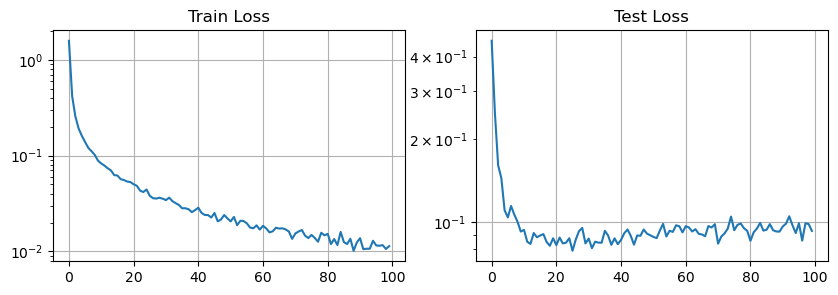

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 100

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_loss_hist = []
test_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, test_loader, loss_function)
    test_loss_hist.append(test_loss)

    if i % 2 == 1:
        show_losses(train_loss_hist, test_loss_hist)

In [ ]:
accuracy, precision, recall, f1 = compute_metrics(model, test_loader)

print("Accuracy (Test):", accuracy)
print("Precision (Test):", precision)
print("Recall (Test):", recall)
print("F1 Score (Test):", f1)

min_loss = min(test_loss_hist)
print("Минимальная ошибка (Test Loss):", min_loss)

Accuracy (Test): 0.9844
Precision (Test): 0.9844160667333582
Recall (Test): 0.9844
F1 Score (Test): 0.984391497712504
Минимальная ошибка (Test Loss): 0.07866060765276416


## Выводы
Из модели убран BatchNorm в силу его достаточно невысокой эффективности. Взамен этого в модели увеличено количество слоев, и после каждого слоя применен dropout. По графику видно, что в данной модели борьба с переобучением реализована лучше всего. В результате метрики незначительно улучшились по сравнению с предыдущими моделями.

## Итоговый отчет по экспериментам

| **№ эксперимента** | **Минимальная ошибка (Loss) на валидации** | **Accuracy (Test)** | **Precision (Test)** | **Recall (Test)** | **F1-score (Test)** |
|:------------------:|:------------------------------------------:|:-------------------:|:--------------------:|:-----------------:|:-------------------:|
|         1          |                   0.083                     |       0.973        |        0.973         |       0.973       |        0.973|
|         2          |                   0.080                     |        0.980        |        0.980         |       0.980       |        0.980        |
|         3          |                   0.096                     |        0.981        |        0.981         |       0.981       |        0.981        |
|         4          |                   0.063                     |        0.982        |        0.982         |       0.982       |        0.982        |
|         5          |                   0.063                     |        0.982        |        0.982         |       0.982       |        0.982        |
|         6          |                   0.079                     |        0.984        |        0.984         |       0.984       |        0.984        |

---

## Результаты

Таким образом, в данной работе было проведено 6 экспериментов, в каждом из которых была рассмотрена своя архитектура модели. Как итог, модель из 6 эксперимента показала лучшие значения на основных метриках. Такой результат неслучаен, данная архитектура создана на основании выводов, сделанных на предыдущих экспериметах (добавлен dropout, увеличено количество эпох до 100, а также увеличено количество скрытых слоев).
